In [1]:
main_path = '../input/monkeypox-image-dataset/Monkeypox Skin Images Dataset (MSID)'

In [2]:
import os

categories = os.listdir(main_path)
categories

['Monkeypox', 'Measles', 'Normal', 'Chickenpox']

In [ ]:
## For data augmentation

#from tensorflow.keras.preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator(
#        rotation_range=25,
#        width_shift_range=0.2,
#        height_shift_range=0.2,
#        rescale=1./255,
#        shear_range=0.2,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        fill_mode='nearest')

#for category in categories:
#  sub_path = os.path.join(main_path,category)

#  for img in os.listdir(sub_path):
#    img_path = os.path.join(sub_path,img)

#    img_arr = cv2.imread(img_path)
#    img_arr = img_arr.reshape((1,) + img_arr.shape)

    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    
#    i = 0
#    for batch in datagen.flow(img_arr, batch_size=1,
#                              save_to_dir=sub_path, save_prefix='AUG', save_format='png'):
#        i += 1
#        if i > 2:
#            break  # otherwise the generator would loop indefinitely

In [3]:
import cv2
from tensorflow.keras.applications import resnet50

data = []

for category in categories:
  sub_path = os.path.join(main_path,category)

  for img in os.listdir(sub_path):
    img_path = os.path.join(sub_path,img)

    img_arr = cv2.imread(img_path)
    img_arr = cv2.resize(img_arr,(224,224))
    
    image=resnet50.preprocess_input(img_arr)
    label=categories.index(category) 

    data.append([image,label])

In [4]:
import random

random.shuffle(data)

In [5]:
X = []
y = []

for features,labels in data:
  X.append(features)
  y.append(labels)

In [6]:
import numpy as np

print(np.shape(X))
print(np.shape(y))

(2989, 224, 224, 3)
(2989,)


In [7]:
X = np.array(X)

In [8]:
from tensorflow.keras.utils import to_categorical

y=to_categorical(y) # onehot encoding of the labels

In [9]:
print(X.shape)
print(y.shape)

(2989, 224, 224, 3)
(2989, 4)


In [10]:
from sklearn.model_selection import train_test_split

# Create the Validation Dataset
Xtrain, Xval, ytrain, yval = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=42)# Create the Test and Final Training Datasets
Xtrain, Xtest, ytrain, ytest = train_test_split(Xtrain, ytrain, train_size=0.78, random_state=42)

In [11]:
len(data)

2989

In [12]:
print(Xtrain.shape)
print(Xtest.shape)
print(Xval.shape)

(2098, 224, 224, 3)
(592, 224, 224, 3)
(299, 224, 224, 3)


In [66]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 4

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [67]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [68]:
# we are using resnet50 for transfer learnin here. So we have imported it
from tensorflow.keras.applications import resnet50

# initializing model with weights='imagenet'i.e. we are carring its original weights
model_resnet=resnet50.ResNet50(weights='imagenet')

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [69]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [70]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [71]:
fit_history = model.fit(
        Xtrain,ytrain,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=(Xtest,ytest),
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/10
10/10 [==============================] - 9s 638ms/step - loss: 0.8486 - accuracy: 0.6768 - val_loss: 0.3915 - val_accuracy: 0.8480
Epoch 2/10
10/10 [==============================] - 4s 444ms/step - loss: 0.3697 - accuracy: 0.8718 - val_loss: 0.3103 - val_accuracy: 0.8936
Epoch 3/10
10/10 [==============================] - 4s 442ms/step - loss: 0.2653 - accuracy: 0.9080 - val_loss: 0.2719 - val_accuracy: 0.9020
Epoch 4/10
10/10 [==============================] - 4s 451ms/step - loss: 0.2074 - accuracy: 0.9337 - val_loss: 0.2510 - val_accuracy: 0.9139
Epoch 5/10
10/10 [==============================] - 4s 443ms/step - loss: 0.1704 - accuracy: 0.9433 - val_loss: 0.2166 - val_accuracy: 0.9240
Epoch 6/10
10/10 [==============================] - 4s 443ms/step - loss: 0.1461 - accuracy: 0.9557 - val_loss: 0.2157 - val_accuracy: 0.9223
Epoch 7/10
10/10 [==============================] - 4s 455ms/step - loss: 0.1293 - accuracy: 0.9628 - val_loss: 0.1960 - val_accuracy: 0.9240
Epoch 

In [61]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


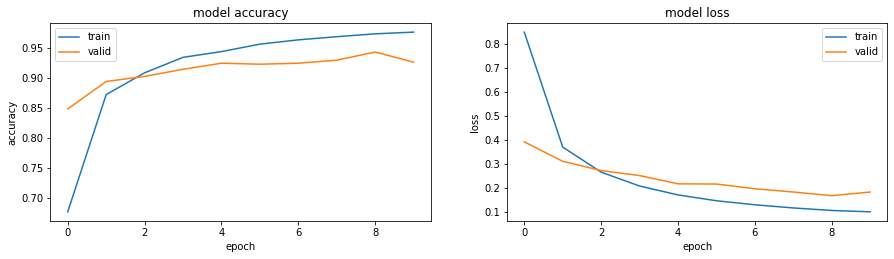

In [72]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [75]:
#Evaluating the model on the data

test_scores = model.evaluate(Xval, yval)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))


10/10 [==============================] - 1s 72ms/step - loss: 0.1843 - accuracy: 0.9264
Testing Accuracy: 92.64%


In [80]:
pred_labels = model.predict(Xval)

In [86]:
yval[40]

array([1., 0., 0., 0.], dtype=float32)

In [87]:
pred_labels[40]

array([0.9694642 , 0.0011126 , 0.02348202, 0.00594114], dtype=float32)

[[0.11082572 0.00099058 0.87865424 0.0095295 ]]


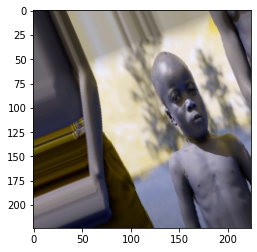

In [96]:
from keras.preprocessing import image

img_path = '../input/monkeypox-image-dataset/Monkeypox Skin Images Dataset (MSID)/Normal/AUG_0_101.png'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = resnet50.preprocess_input(x)
print(model.predict(x))
plt.imshow(img)

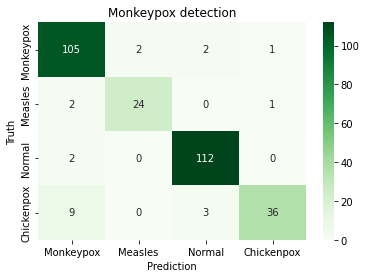

In [91]:
# Show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(yval, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=categories, yticklabels=categories)

plt.title('Monkeypox detection')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [92]:
# Calculate some ML metrics on average
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy score : ', accuracy_score(test_ls, pred_ls))
print('Precision score : ', precision_score(test_ls, pred_ls, average='weighted'))
print('Recall score : ', recall_score(test_ls, pred_ls, average='weighted'))
print('F1 score : ', f1_score(test_ls, pred_ls, average='weighted'))

Accuracy score :  0.9264214046822743
Precision score :  0.9277803417859924
Recall score :  0.9264214046822743
F1 score :  0.924749567623565


In [94]:
model.save('saved_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
